# Import JSON Database containing 5SS mechanisms

In [1]:
import json
with open('database5SS.txt') as f:
    json_data = json.load(f)
#print(json.dumps(json_data, indent=4))

# Create numpy arrays for data

In [2]:
import numpy as np

MechList=[];
CplrPathList=[];
for d in json_data:
    MechList.append(np.asarray(d["Mech"]))
    CplrPathList.append(np.asarray(d["CplrPath"]))

# Plot sample Coupler curve data

In [3]:
#%matplotlib inline
%matplotlib notebook

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from IPython import display
from numpy import linalg as LA


def plotPath(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    zline=Pts[:,2]
    ax.plot3D(xline, yline, zline, color)
    ax.auto_scale_xyz([-limit, limit], [-limit, limit], [-limit, limit])

def plotXYZ(center, RotMat, ax):
    C=np.vstack((center,center,center))
    R=RotMat
    r=(1,0,0)
    g=(0,1,0)
    b=(0,0,1)
    ax.quiver(C[:,0], C[:,1], C[:,2], R[:,0], R[:,1], R[:,2],color=(r,g,b,r,r,g,g,b,b))

<IPython.core.display.Javascript object>


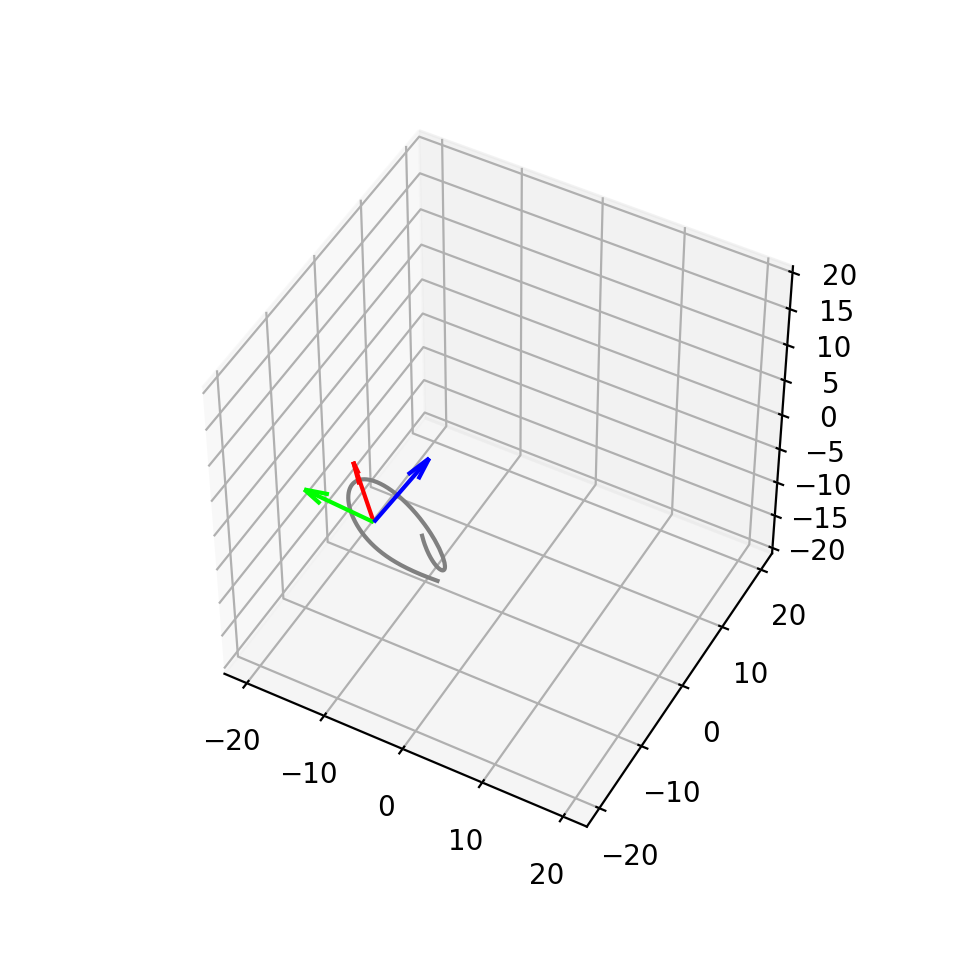

In [12]:
Pts=CplrPathList[9]
fig = plt.figure(figsize=1*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plotPath(Pts, ax, 20)
        
C=np.mean(Pts,axis=0)
Covariance_Mat=np.cov(Pts,rowvar=0)
sing_vec=LA.svd(Covariance_Mat)[0]
R=sing_vec.T*10
plotXYZ(C, R, ax)

<IPython.core.display.Javascript object>


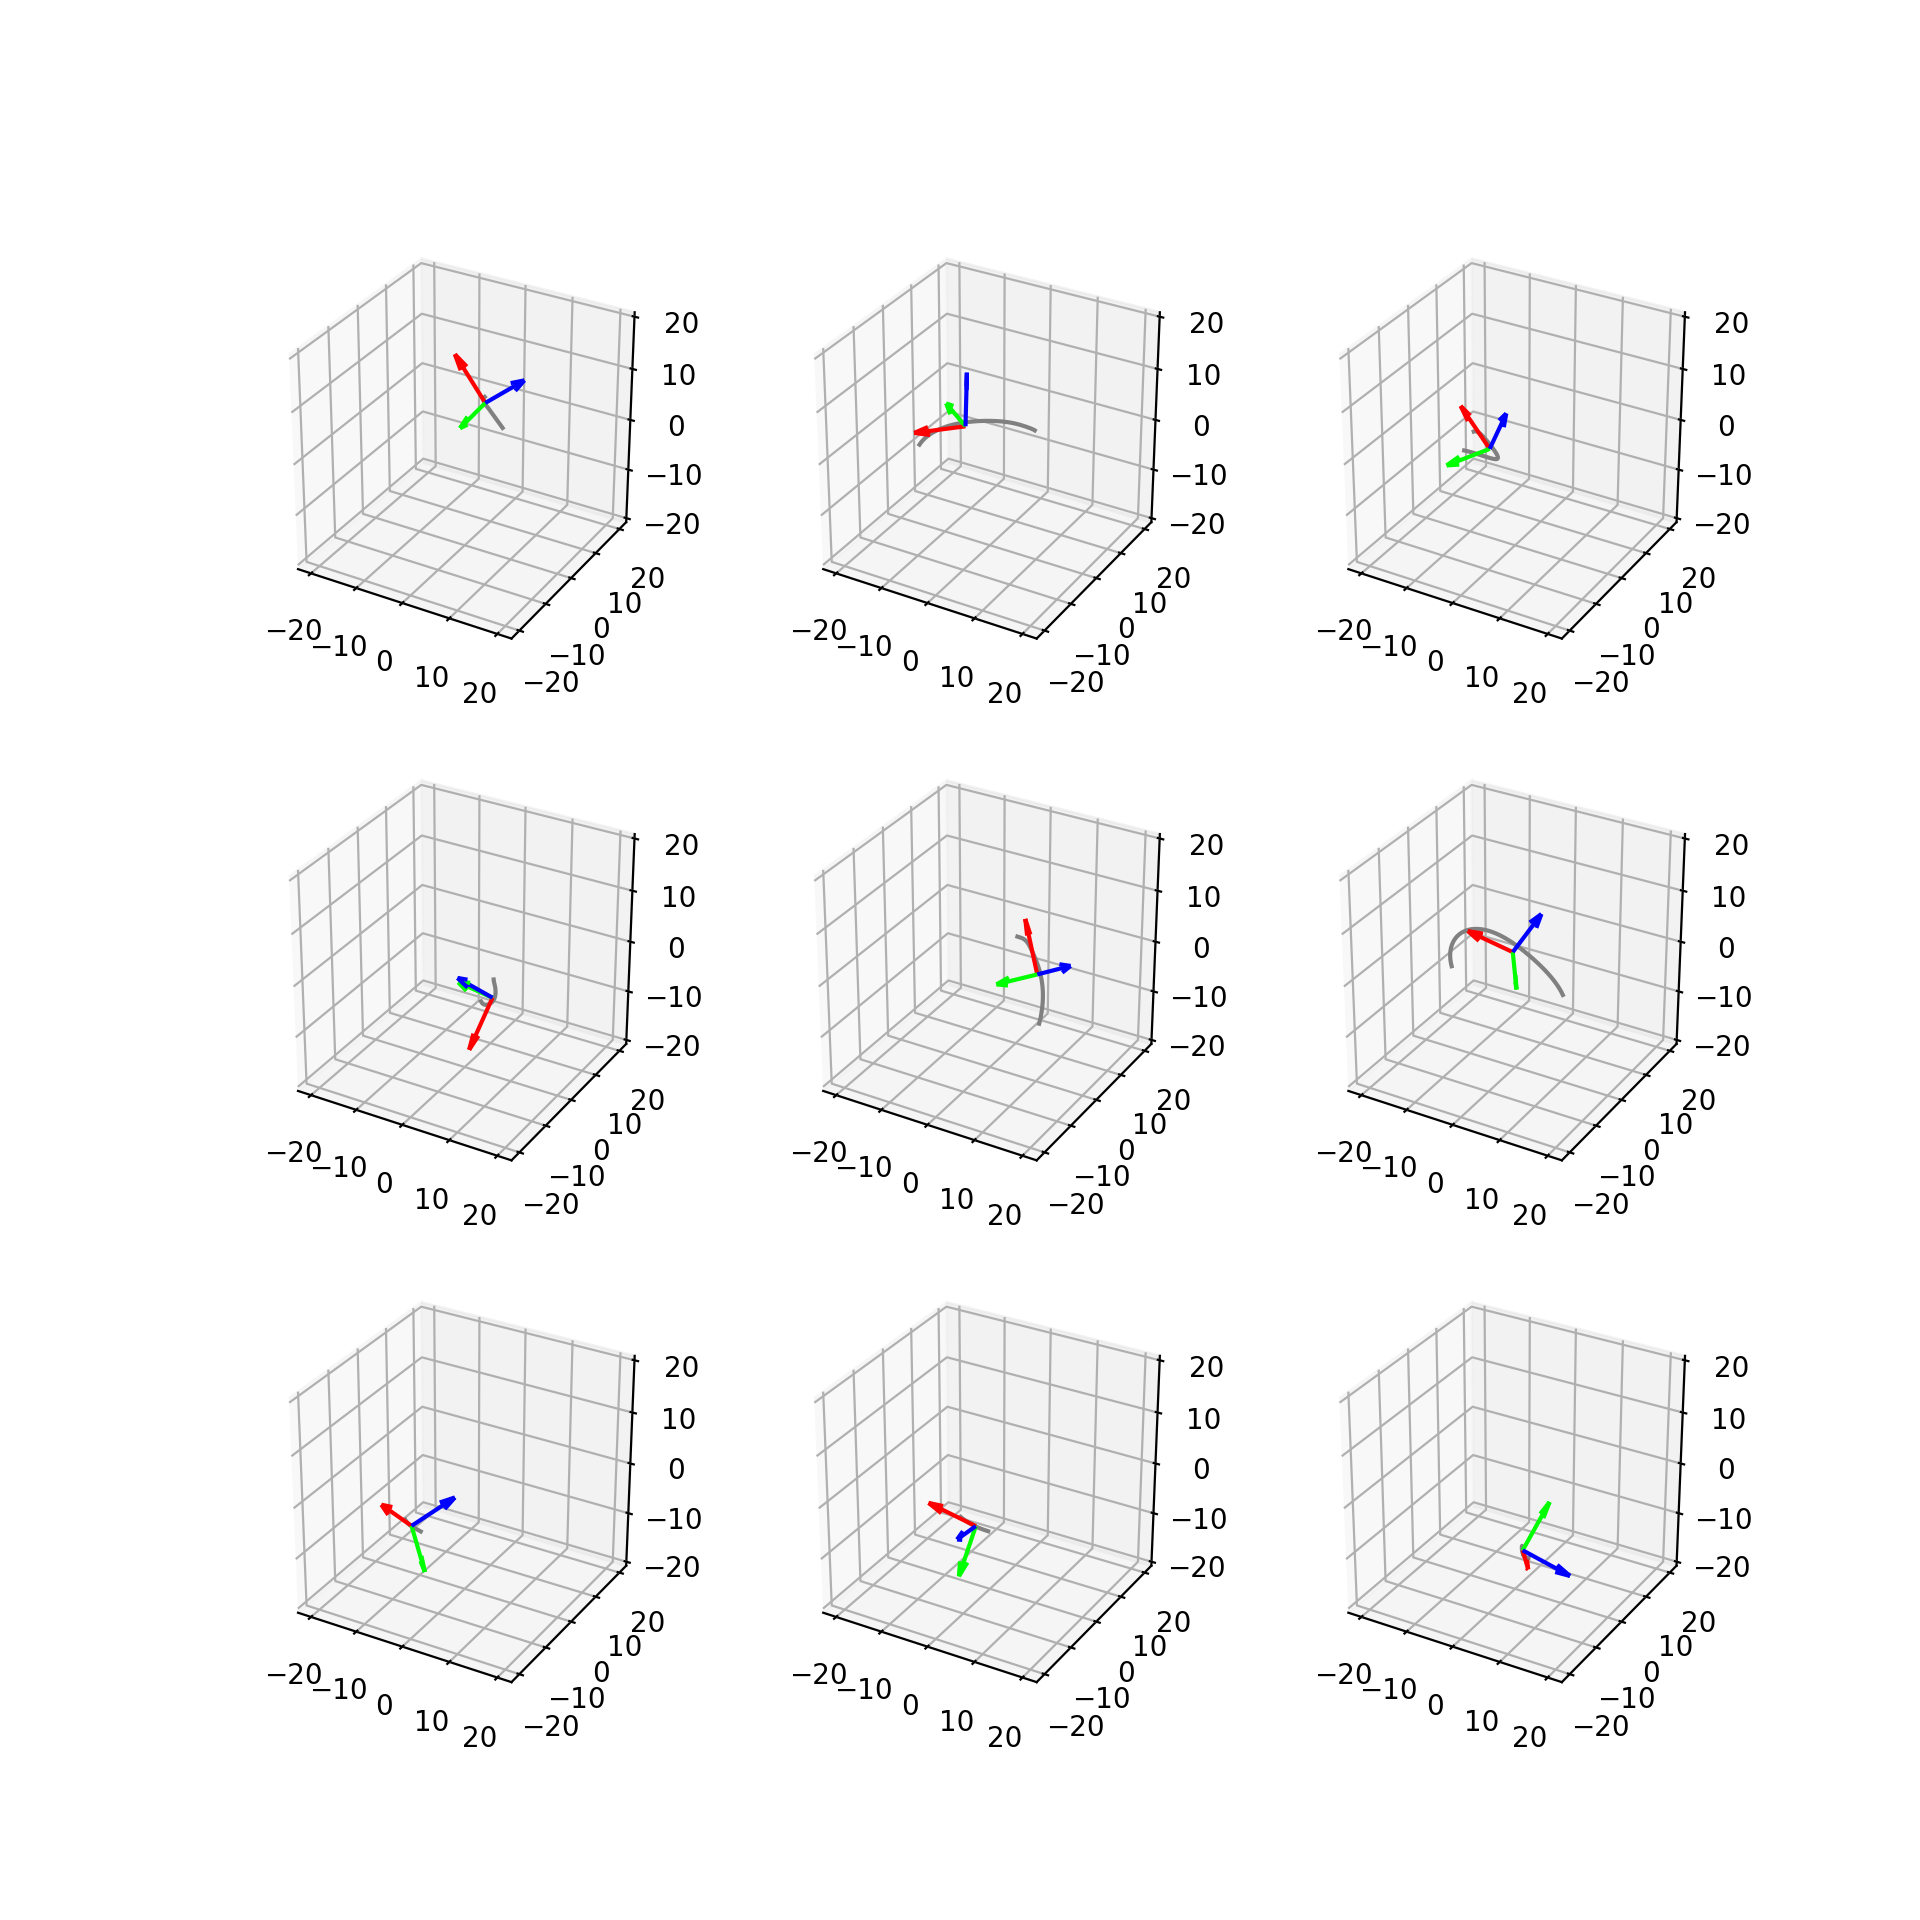

In [13]:
rows=3
cols=3

path_index=0;
fig = plt.figure(figsize=2*plt.figaspect(cols/rows))
for i in range(rows):
    for j in range(cols):
        Pts=CplrPathList[path_index]
        path_index=path_index+1
        ax = fig.add_subplot(cols, rows, path_index, projection='3d')
        plotPath(Pts, ax, 20)
        
        C=np.mean(Pts,axis=0)
        Covariance_Mat=np.cov(Pts,rowvar=0)
        sing_vec=LA.svd(Covariance_Mat)[0]
        R=sing_vec.T*10
        plotXYZ(C, R, ax)

# Normalize number of points in each path to 100 pts

As can be seen in the histogram, the number of points in each coupler path ranges from 2 to 2782 points. To use it in a ML framework, we resample each curve and normalize them to contain 100 points each.

<IPython.core.display.Javascript object>


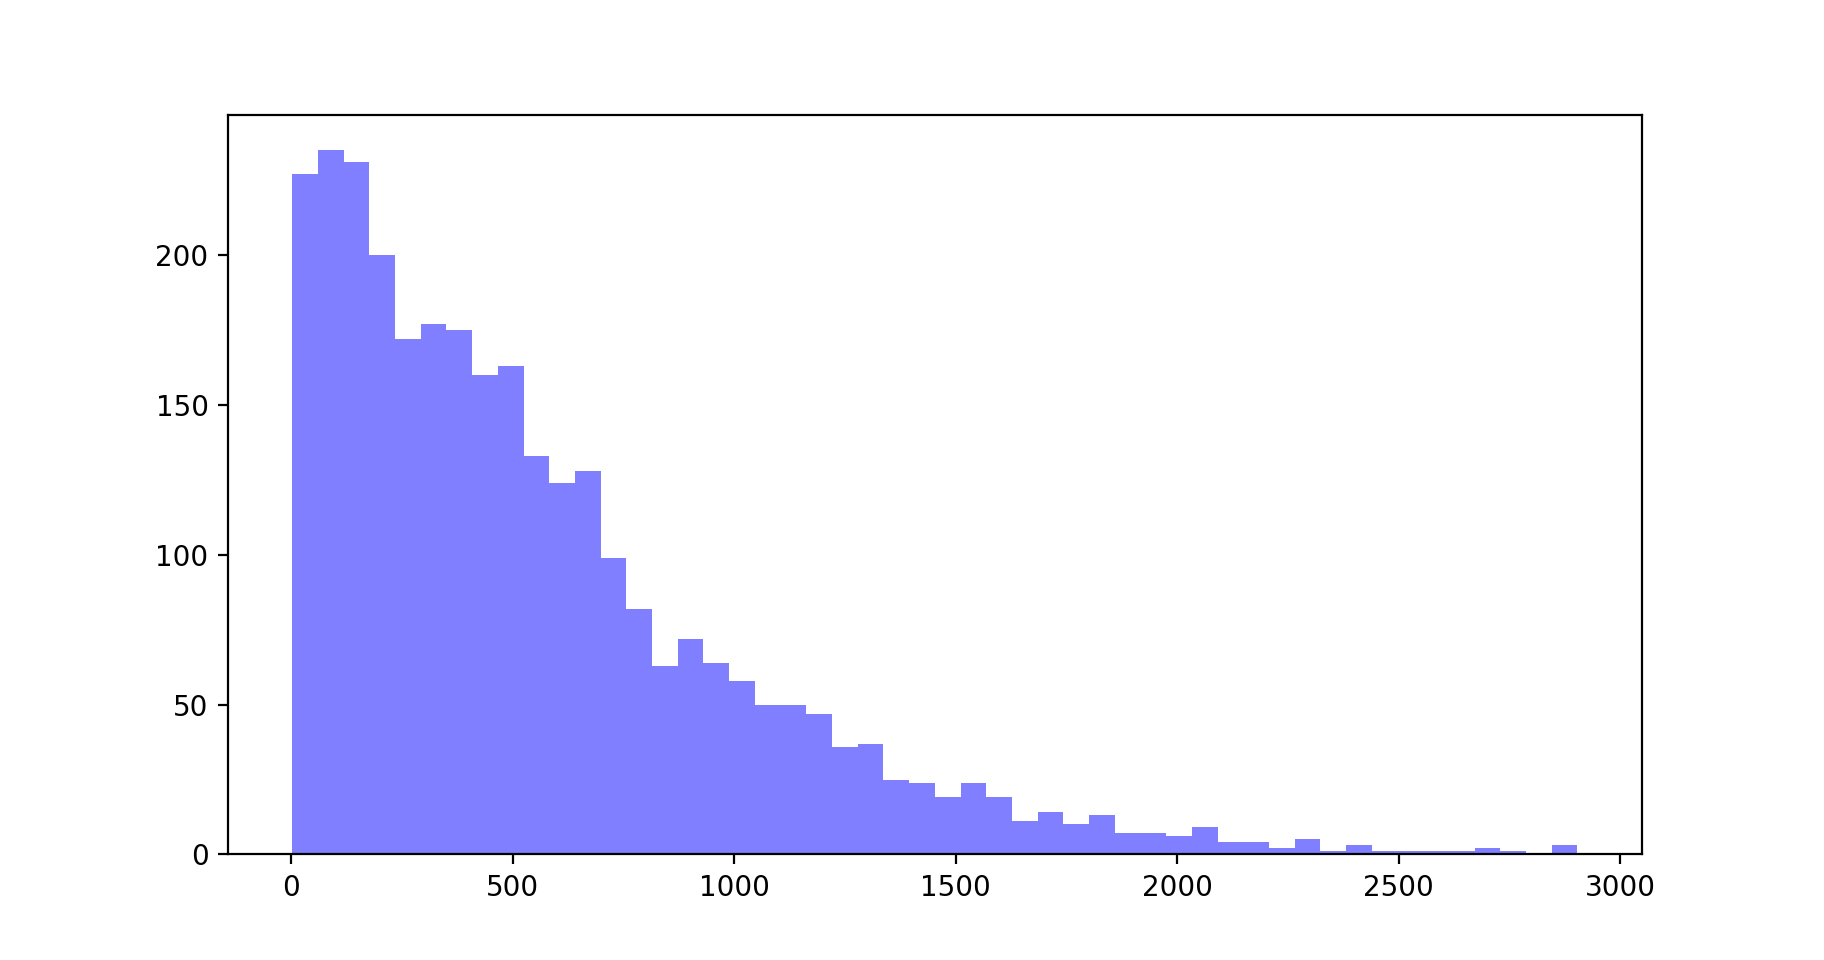

The minimum number of points in a coupler curve are: 2
The maximum number of points in a coupler curve are: 2903


In [14]:
no_Path_Pts=[];
for i in range(len(CplrPathList)):
    no_Path_Pts.append(CplrPathList[i].shape[0])

fig = plt.figure(figsize=1*plt.figaspect(1/1.9))
n, bins, patches = plt.hist(no_Path_Pts, 50, facecolor='blue', alpha=0.5)
plt.show()

print("The minimum number of points in a coupler curve are: "+ str(min(no_Path_Pts)))
print("The maximum number of points in a coupler curve are: "+ str(max(no_Path_Pts)))

In [15]:
# Remove Data with less than 10 points due to too less curve data
print("Database size before removing data: " + str(len(CplrPathList)))
no_Path_Pts=np.array(no_Path_Pts)
leq10_index=np.where(no_Path_Pts<10)

CplrPathList=np.delete(CplrPathList, leq10_index)
MechList=np.delete(MechList, leq10_index)
print("Database size after removing data: " + str(len(CplrPathList)))

Database size before removing data: 3000
Database size after removing data: 2967


In [16]:
from scipy import interpolate

def normalizePathPts(Path, num_pts=100):
    xp=Path[:,0]
    yp=Path[:,1]
    zp=Path[:,2]
    
    # Check for duplicate points as interpolation routine errors out
    okay = np.where(np.abs(np.diff(xp)) + np.abs(np.diff(yp)) + np.abs(np.diff(zp)) > 0)
    xp = np.r_[xp[okay], xp[-1]]
    yp = np.r_[yp[okay], yp[-1]]
    zp = np.r_[zp[okay], zp[-1]]

    # Fit cubic B-spline to the data points
    tck, u =interpolate.splprep([xp,yp,zp],s=.01)
    u_fine = np.linspace(0,1,num_pts)
    x_100, y_100, z_100 = interpolate.splev(u_fine, tck)
    Path_100 = np.vstack(([x_100],[y_100],[z_100])).T
    
    return Path_100

<IPython.core.display.Javascript object>


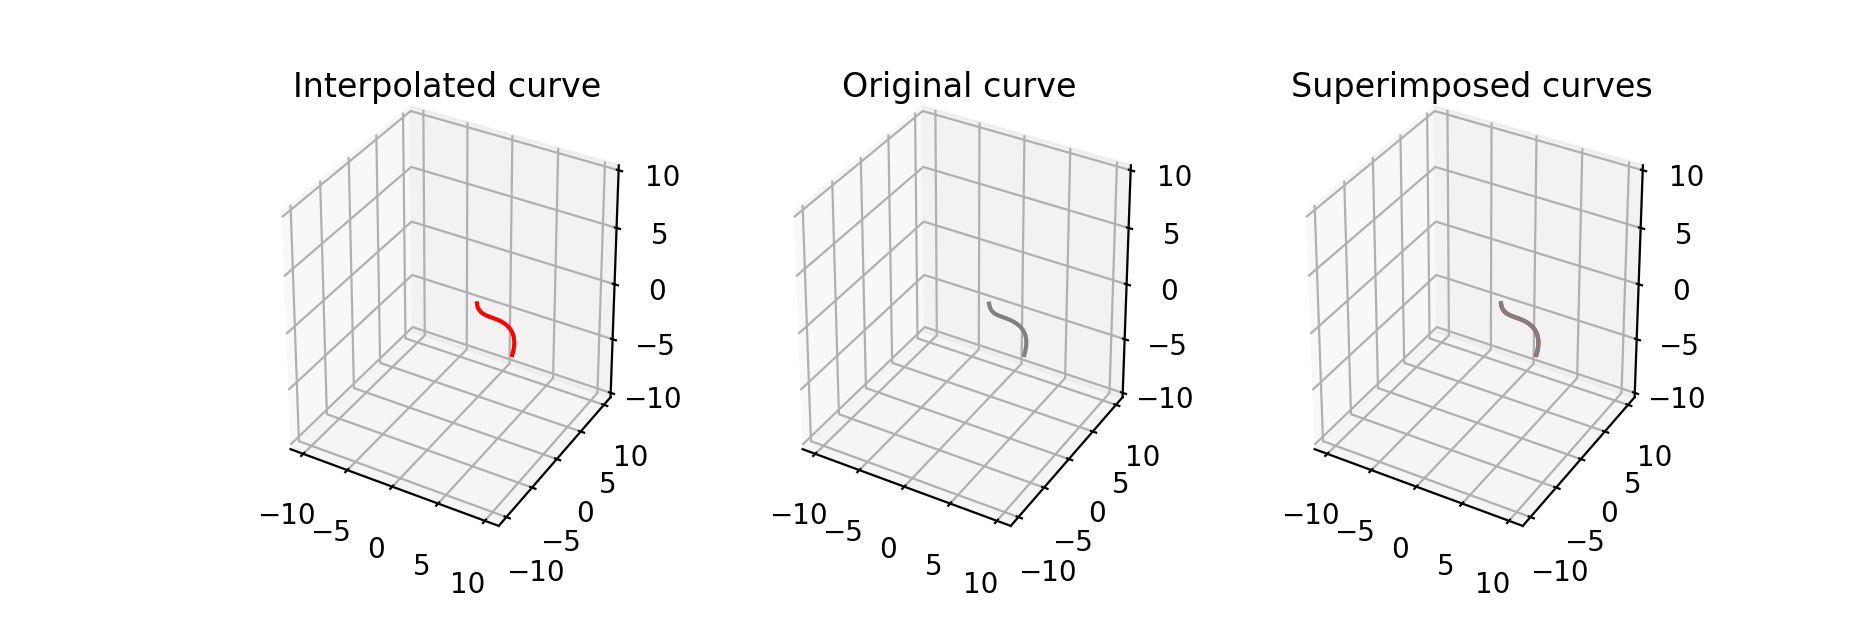

In [17]:
Path=CplrPathList[23]
Path_100=normalizePathPts(Path)

fig = plt.figure(figsize=.65*plt.figaspect(1/3))
ax = fig.add_subplot(1, 3, 1, projection='3d')
plt.title("Interpolated curve")
plotPath(Path_100, ax, 10, color='r')
ax = fig.add_subplot(1, 3, 2, projection='3d')
plt.title("Original curve")
plotPath(Path, ax, 10, color='grey')
ax = fig.add_subplot(1, 3, 3, projection='3d')
plt.title("Superimposed curves")
plotPath(Path_100, ax, 10, color='r')
plotPath(Path, ax, 10, color='grey')

In [18]:
MechList100=MechList;
CplrPathList100=[];

for i in range(len(CplrPathList)):
    Path=CplrPathList[i]
    Path_100=normalizePathPts(Path)
    CplrPathList100.append(Path_100)

# Normalize Data (Translation,Rotation, Scaling)

- Translation: Average of all points moved to origin.
- Rotation: Principal axes rotated to align with x-axis
- Scaling: Divide points by maximum standard deviation

In [19]:
def normalizePath(Path):
    #TRANSLATION
    T=np.mean(Path,axis=0)
    Trans_Path=Path-T

    #ROTATION
    Covariance_Mat=np.cov(Trans_Path,rowvar=0)
    sing_vec=LA.svd(Covariance_Mat)[0]
    R=sing_vec.T
    Rot_Path=np.matmul(R,Trans_Path.T).T
    
    #SCALING
    S=np.max(np.std(Rot_Path,axis=0))
    Scale_Path=Rot_Path/S

    return Scale_Path, T, R, S

def normalizeMech(Mech, Translate, Rotate, Scale):
    Trans_Mech=Mech-Translate
    Rot_Mech=np.matmul(Rotate,Trans_Mech.T).T
    Scale_Mech=Rot_Mech/Scale
    return Scale_Mech

<IPython.core.display.Javascript object>


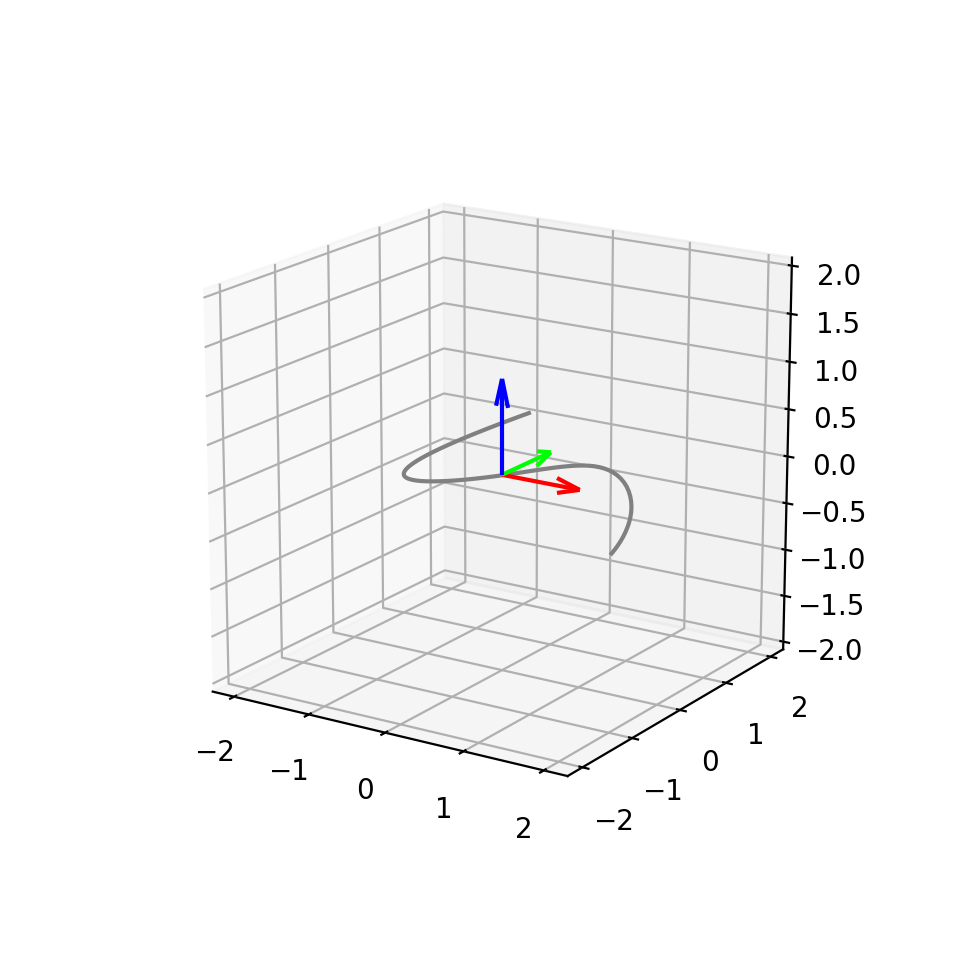

In [20]:
Path=CplrPathList100[26]
nPath, T, R, S=normalizePath(Path)
fig = plt.figure(figsize=1*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plotPath(nPath, ax, 2)
plotXYZ(np.zeros((1, 3)), np.identity(3), ax)

In [21]:
Norm100MechList=[];
Norm100CplrPathList=[];

for i in range(len(CplrPathList)):
    Path=CplrPathList100[i]
    Mech=MechList100[i]
    
    nPath, T, R, S=normalizePath(Path)
    nMech=normalizeMech(Mech, T, R, S)
    
    Norm100MechList.append(nMech)
    Norm100CplrPathList.append(nPath)

# Normalize coordinates in x, y, z axis independently

due to our path normalization technique, we orient maximum variance direction with x axis and minimum variance in z axis. This bias leads to the VAE learning X and Y axis data predominanity. Due to this each axis data need to be scaled independently even though the aspect ration of the path is not conserved.

In [22]:
def scalePath(Path):
    S=np.std(Path,axis=0)
    Scale_Path=Path
    Scale_Path[:,0]=Scale_Path[:,0]/S[0]
    Scale_Path[:,1]=Scale_Path[:,1]/S[1]
    Scale_Path[:,2]=Scale_Path[:,2]/S[2]
    return Scale_Path


for i in range(len(Norm100CplrPathList)):
    Norm100CplrPathList[i]=scalePath(Norm100CplrPathList[i])

<IPython.core.display.Javascript object>


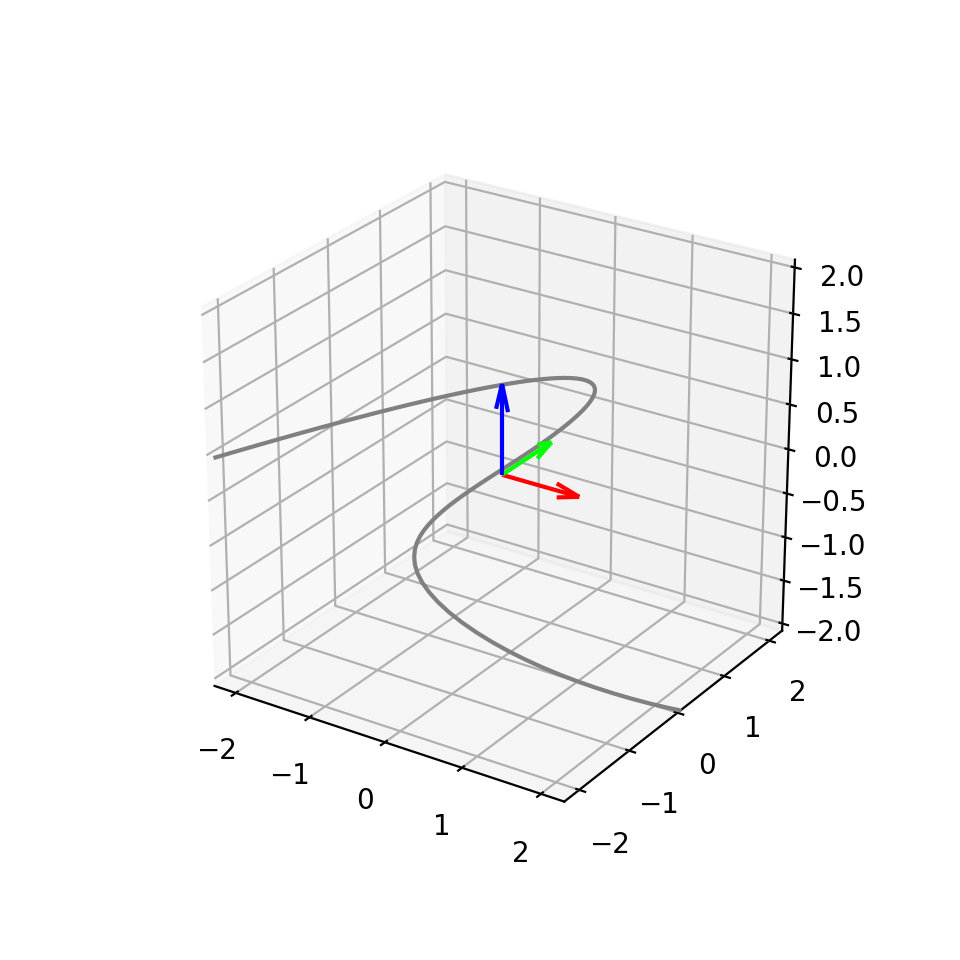

In [23]:
Path=Norm100CplrPathList[26]
nPath, T, R, S=normalizePath(Path)
fig = plt.figure(figsize=1*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plotPath(nPath, ax, 2)
plotXYZ(np.zeros((1, 3)), np.identity(3), ax)

# Normalize the variety of data

In its present state, the database has more samples of coupler paths which are more probable while lesser samples of other more diverse. However, we would like our NN to handle all types of coupler paths with same efficiency and accuracy. To overcome this bias, we select a limited number of diverse paths from the complete database. Thus, this new balanced dataset contains equal samples of unique and diverse paths.

# Find Path Descriptors using Z space of VAE

VAE are good at:
- **dimensionality reduction** for data visualization
- **data denoising**

Dimensions of Input space= n x 100 x 3

Dimensions of Latent space (z-space)= 2

In [24]:
x= np.asarray(Norm100CplrPathList)

# Split data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train, x_test, _, _ = train_test_split(x, x, test_size=0.2)

In [25]:
from keras.layers import Input, Dense, Flatten, Reshape, SeparableConv1D
from keras.models import Model
from keras.layers import LeakyReLU
from keras import regularizers


def autoEncoderZ2():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    x=Dense(10, activation='relu')(x)
    encoded=Dense(2, activation='relu')(x)
    #encoded=Dense(10, activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)

    # Decoding
    x=Dense(10, activation='relu')(encoded)
    x=Dense(30, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    autoencoder.summary()
    
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

def autoEncoderZ3():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    x=Dense(10, activation='relu')(x)
    encoded=Dense(3, activation='relu')(x)
    #encoded=Dense(10, activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)

    # Decoding
    x=Dense(10, activation='relu')(encoded)
    x=Dense(30, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    autoencoder.summary()
    
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

def autoEncoderZ10():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    encoded=Dense(10, activation='relu')(x)
    #encoded=Dense(10, activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)

    # Decoding
    x=Dense(30, activation='relu')(encoded)
    x=Dense(100, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    autoencoder.summary()
    
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

def autoEncoderZ50():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(200, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    encoded=Dense(50, activation='relu')(x)
    #encoded=Dense(10, activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)

    # Decoding
    x=Dense(100, activation='relu')(encoded)
    x=Dense(200, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    autoencoder.summary()
    
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder


def autoEncoderleakyZ10():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100)(x)
    x=LeakyReLU(alpha=0.01)(x)
    x=Dense(30)(x)
    x=LeakyReLU(alpha=0.01)(x)
    x=Dense(10)(x)
    #x=Dense(10,activity_regularizer=regularizers.l1(10e-5))(x)
    encoded=LeakyReLU(alpha=0.01)(x)

    # Decoding
    x=Dense(30)(encoded)
    x=LeakyReLU(alpha=0.01)(x)
    x=Dense(100)(x)
    x=LeakyReLU(alpha=0.01)(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    autoencoder.summary()
    
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

def autoEncoderCov():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=SeparableConv1D(5,3)(inp_curve)
    x=Dense(100)(x)
    x=LeakyReLU(alpha=0.01)(x)
    x=Dense(30)(x)
    x=LeakyReLU(alpha=0.01)(x)
    x=Dense(10,activity_regularizer=regularizers.l1(10e-5))(x)
    encoded=LeakyReLU(alpha=0.01)(x)

    # Decoding
    x=Dense(30)(encoded)
    x=LeakyReLU(alpha=0.01)(x)
    x=Dense(100)(x)
    x=LeakyReLU(alpha=0.01)(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)


    autoencoder = Model(inp_curve, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    autoencoder.summary()
    
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

Using TensorFlow backend.






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 3)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                40        
______

<IPython.core.display.Javascript object>


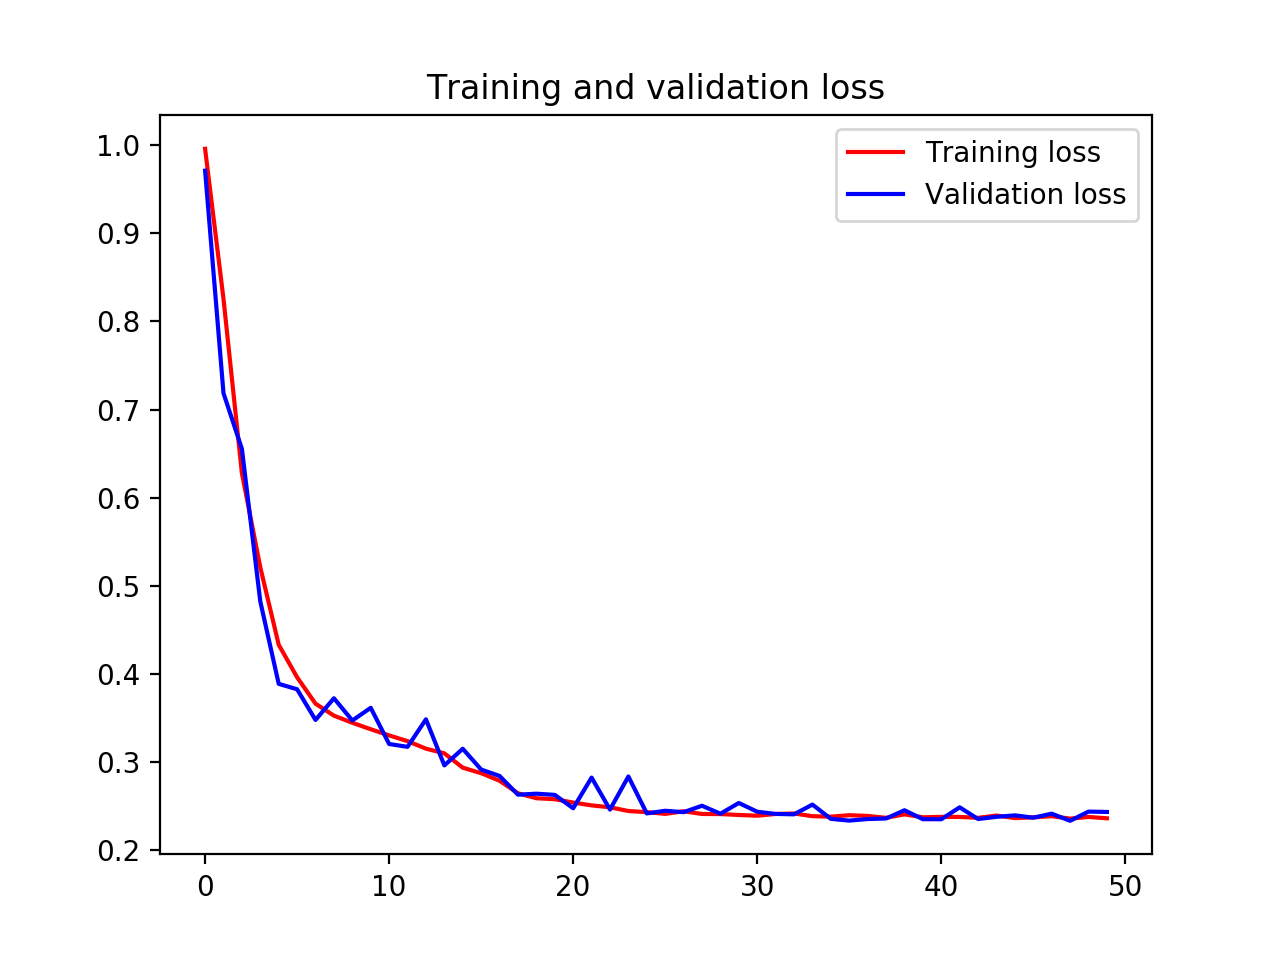

In [26]:
autoencoder, encoder=autoEncoderZ3()
epochs=50
autoencoder_train=autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=64, shuffle=True, validation_data=(x_test, x_test), verbose=2)
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


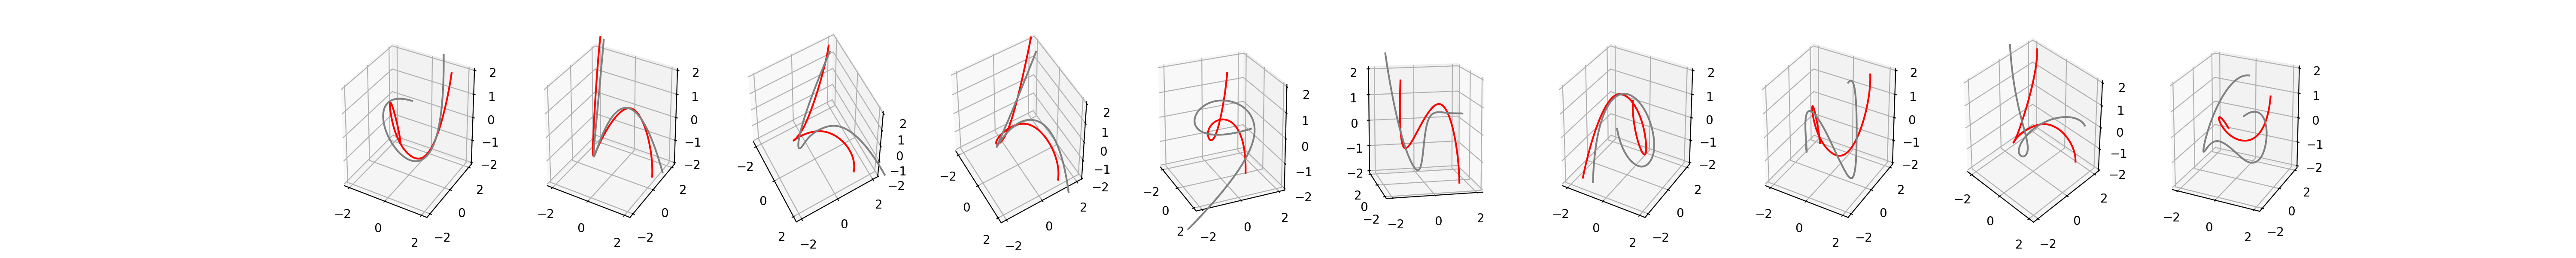

In [27]:
predicted_curve = autoencoder.predict(x_test)
z_param = encoder.predict(x_test)
#print(z_param)
#print(predicted_curve)

n = 10  # how many digits we will display
plt.figure(figsize=(3*n, 3))
for i in range(n):
    ax = plt.subplot(1, n, i + 1, projection='3d')
    
    # Fit cubic B-spline to the predicted points
    xp=predicted_curve[i,:,0]
    yp=predicted_curve[i,:,1]
    zp=predicted_curve[i,:,2]
    tck, u =interpolate.splprep([xp,yp,zp],s=1)
    num_pts=100
    u_fine = np.linspace(0,1,num_pts)
    x_100, y_100, z_100 = interpolate.splev(u_fine, tck)
    Path_100 = np.vstack(([x_100],[y_100],[z_100])).T
    
    # display reconstruction
    plotPath(Path_100, ax, 2,'r' )
    # display original
    plotPath(x_test[i], ax, 2)
    
plt.show()

# Perform Hierarchical Clustering (K-Mean)(also try Dendrogram)

In [28]:
print(z_param)

[[ 0.68618184 -0.          0.6395249 ]
 [12.829138   -0.         15.265045  ]
 [11.844064   -0.         14.577268  ]
 ...
 [-0.         -0.          9.453572  ]
 [ 9.4750595  -0.         12.562719  ]
 [11.690671   -0.          8.317663  ]]


<IPython.core.display.Javascript object>


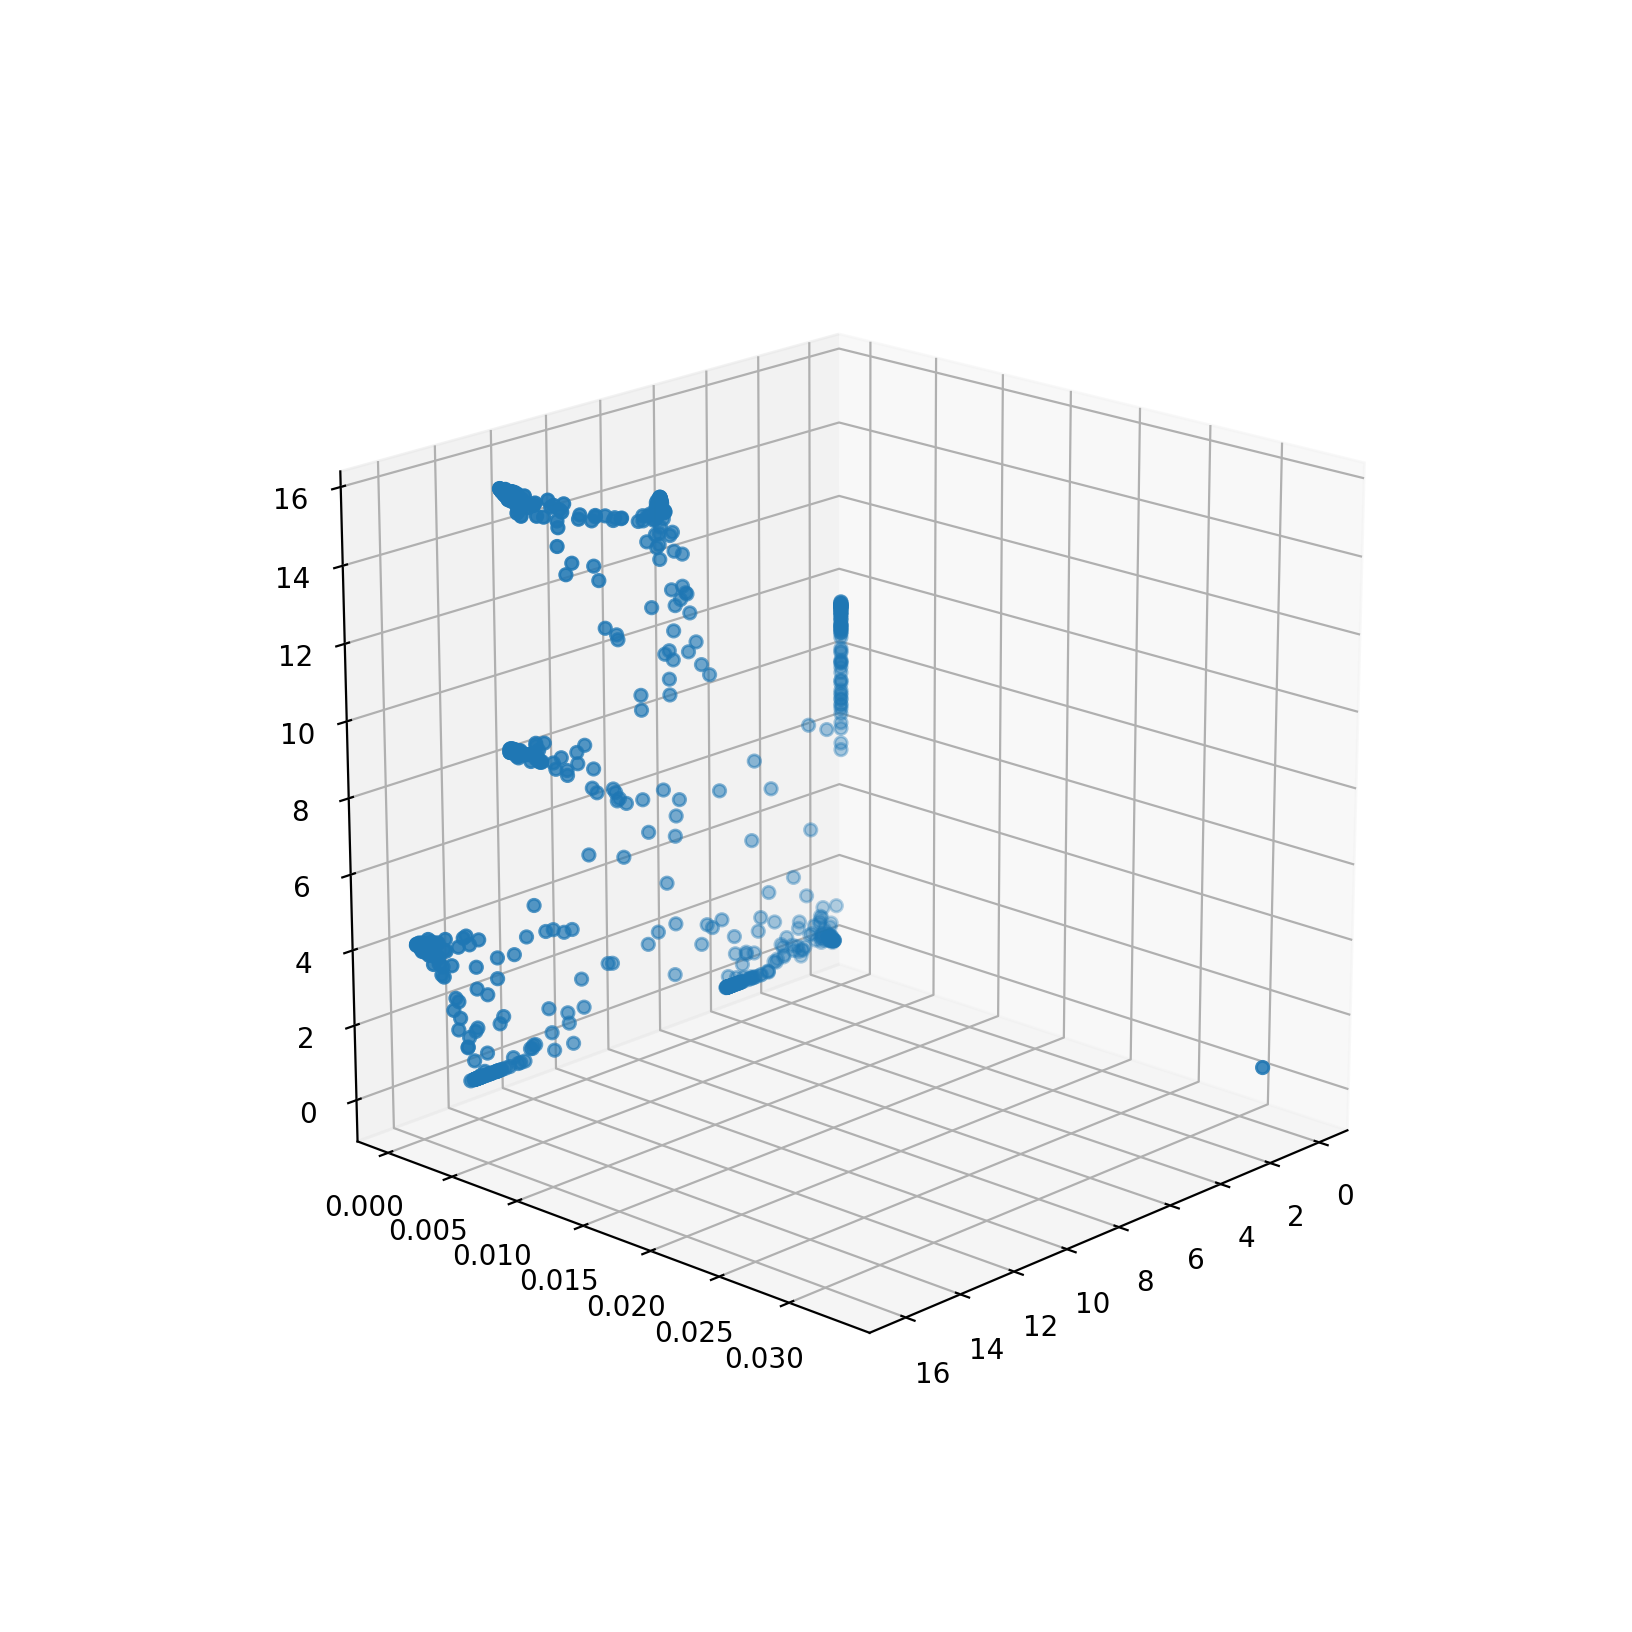

In [29]:
fig = plt.figure(figsize=1.7*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(z_param[:,0],z_param[:,1],z_param[:,2])

<IPython.core.display.Javascript object>


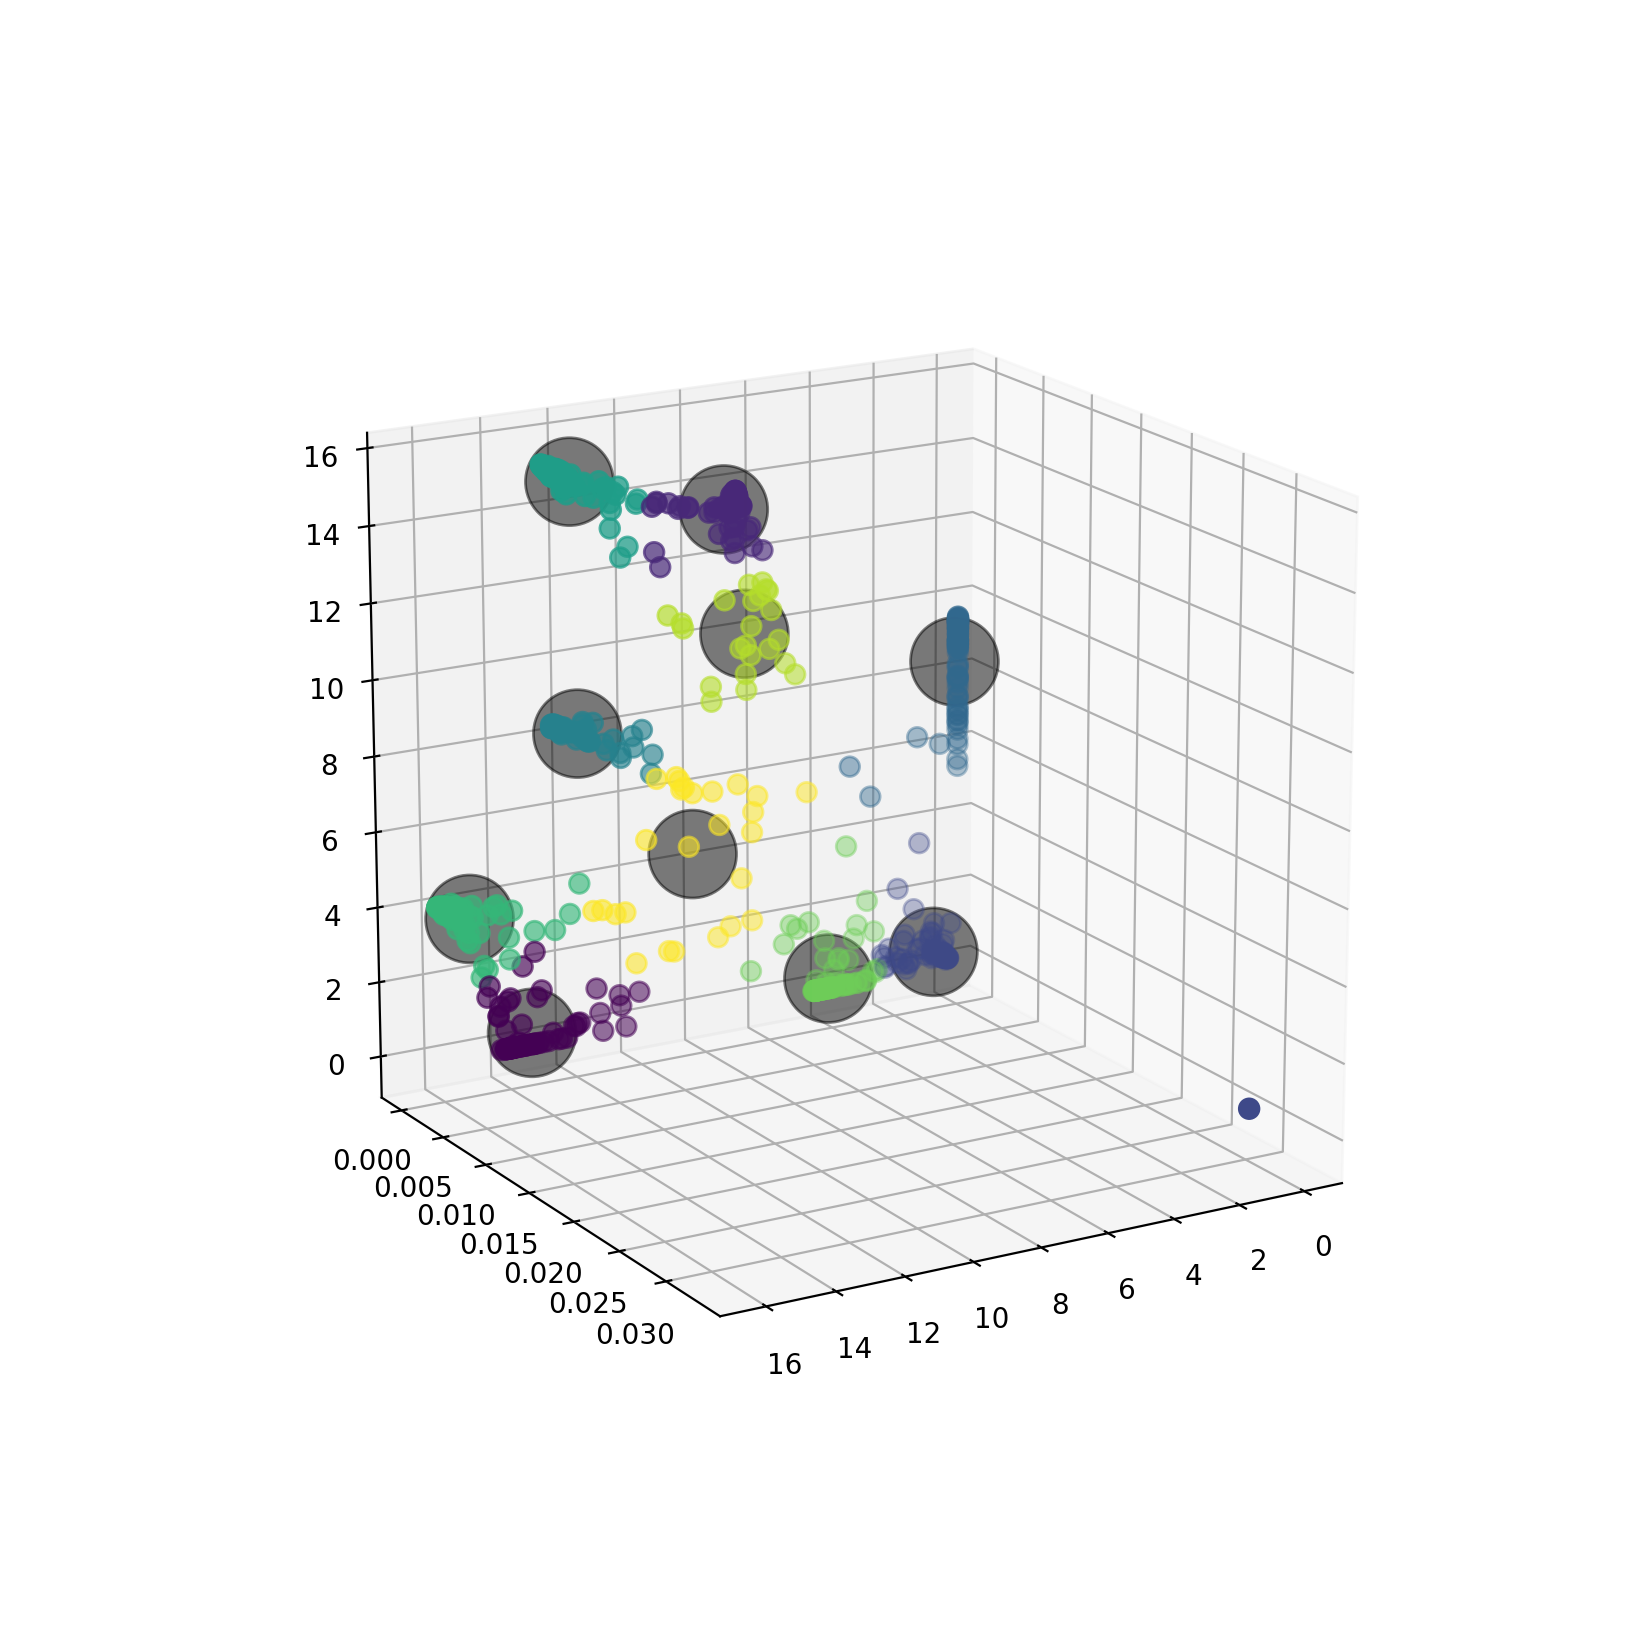

In [30]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
kmeans.fit(z_param)
y_kmeans = kmeans.predict(z_param)

centers = kmeans.cluster_centers_
fig = plt.figure(figsize=1.7*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(z_param[:, 0], z_param[:, 1], z_param[:, 2], c=y_kmeans, s=50, cmap='viridis')
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', s=1000, alpha=0.5);

# Find similar paths using KNN on Cluster Centers